# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `8`
* Students: `Matyas Lustig, Aurélien Pomini, David Salathé, Justine Weber`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

In [2]:
airports_ds = pd.read_csv('data/airports.dat', header = None, encoding='utf-8', names = ["Airport ID", "Name"
                                                                                         , "City", "Country", 
                              "IATA", "ICAO", "Latitude", "Longitude", "Altitude", 
                              "Timezone", "DST", "Tz db time zone", "Type", "Source"])
#airports_ds['newidx'] = airports_ds.index

routes = pd.read_csv('data/routes.dat', sep=',', encoding='utf-8', engine='python', 
                     names = ["Airline", "Airline_ID", "Source_airport", "Source_airport_ID", 
                              "Destination_airport", "Destination_airport_ID", "Codeshare", "Stops", "Equipment"]
                     , na_values=['\\N'])

# We only keep the "active" airports for our nodes
airports = pd.concat([routes["Source_airport_ID"],routes["Destination_airport_ID"]], axis=0)
airports = airports.drop_duplicates()

features = airports_ds[airports_ds['Airport ID'].isin(airports)]

features = features.set_index(pd.Series(range(len(features))))
features = features.assign(newidx=pd.Series(range(len(features))).values)


print("Number of airports in the airports.dat file:", len(airports_ds))
print("Number of \"active\" airports in the routes.dat file:", len(features))
features.head(4)

Number of airports in the airports.dat file: 7184
Number of "active" airports in the routes.dat file: 3186


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz db time zone,Type,Source,newidx
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports,0
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports,1
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports,2
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports,3


**Comments:** <br>
We have noticed that in there are lots of airports in the airports.dat file, which don't appear in the routes.dat file, i.e. they are connected to nothing. We have decided to remove those nodes from our dataframe and not use them. <br>
The "newidx" is used later, for computing the adjacency matrix.

### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in the  [graph from edge list]() demo.

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. In the [graph from features]() demo Benjamin showed you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

In [3]:
# CREATING DATAFRAME OF DESTINATION AND SOURCE IATA FOR EACH ROUTE WITH ALL THE ACTIVE AIRPORTS
idx_IATA = features[['IATA', 'newidx']]
routes_srcdest = routes[['Source_airport', 'Destination_airport']]

# Left join because we preserve the airports from routes, even if you don't have features on them
idx_src = routes_srcdest.merge(right=idx_IATA, how='left', left_on='Source_airport', right_on='IATA')
idx_src_dest = idx_src.merge(right=idx_IATA, how='left', left_on='Destination_airport', right_on='IATA', suffixes=['_src', '_dest']).drop(columns=["IATA_src", "IATA_dest"])

In [4]:
n_nodes = len(features)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
unweight_adj = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in idx_src_dest.iterrows():

    if pd.isnull(row.newidx_src) or pd.isnull(row.newidx_dest):
        continue
    i, j = int(row.newidx_src), int(row.newidx_dest)

    unweight_adj[i, j] = 1
    
    adjacency[i, j] = adjacency[i, j] + 1

adjacency.max()

20

**Comments :** <br>
We have noticed that, in the constructed adjacency matrix, their are still some nodes which are connected to nothing (see cell below) : the sum of their row and column is zero, i.e. they are neither source nor destination of any route. <br>
This comes from the fact that some routes in the route dataset link these airports to airports which are not in the airports dataset. Therefore we have no information on these nodes. <br>
We have decided to remove them from our network for that reason. We also need to recompute the _newidx_ of these nodes, in the _features_ dataframe, and delete the rows and columns of the adjacency matrix contaning only zeros.

In [5]:
a = adjacency.sum(axis=1)
b = adjacency.sum(axis=0)

zero_in = np.argwhere(a==0)
zero_out = np.argwhere(b==0)

print("The following values are indices of airports which are connected to nothing :")
no_connection = []

for value in zero_in :
    if np.isin(value[0],zero_out):
        no_connection.append(value[0])
        
print(no_connection)

print("\nTheses airports are the following:")

print(features.loc[features['newidx'].isin(no_connection), ['IATA', 'City', 'Country']])

The following values are indices of airports which are connected to nothing :
[1522, 1523, 2643, 3027, 3029, 3040, 3088]

Theses airports are the following:
     IATA              City         Country
1522  RJA       Rajahmundry           India
1523  TIR          Tirupeti           India
2643  LPS             Lopez   United States
3027  AKI             Akiak   United States
3029  TKJ               Tok   United States
3040  SPB  Charlotte Amalie  Virgin Islands
3088  AGM      Angmagssalik       Greenland


Then we drop the unconnected airports from the feature table, and we adjust the indices.

In [6]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DROPS COLUMNS EACH TIME
features = features.drop(features.index[no_connection])
features = features.set_index(pd.Series(range(len(features))))
features = features.assign(newidx=pd.Series(range(len(features))).values)

In [7]:
features.npi

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz db time zone,Type,Source,newidx
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports,0
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports,1
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports,2
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports,3
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports,4
5,6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby,airport,OurAirports,5
6,7,Narsarsuaq Airport,Narssarssuaq,Greenland,UAK,BGBW,61.160500,-45.425999,112,-3,E,America/Godthab,airport,OurAirports,6
7,8,Godthaab / Nuuk Airport,Godthaab,Greenland,GOH,BGGH,64.190903,-51.678101,283,-3,E,America/Godthab,airport,OurAirports,7
8,9,Kangerlussuaq Airport,Sondrestrom,Greenland,SFJ,BGSF,67.012222,-50.711603,165,-3,E,America/Godthab,airport,OurAirports,8
9,10,Thule Air Base,Thule,Greenland,THU,BGTL,76.531197,-68.703201,251,-4,E,America/Thule,airport,OurAirports,9


Finally we delete the corresponding rows and columns of the adjacency matrix

In [9]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DELETES ROWS & COLUMNS EACH TIME
adjacency = np.delete(adjacency, no_connection, 0)
adjacency = np.delete(adjacency, no_connection, 1)
unweight_adj = np.delete(unweight_adj, no_connection, 0)
unweight_adj = np.delete(unweight_adj, no_connection, 1)

**Comments:** <br>
We have decided to create a weighted and an unweighted adjacency matrix at the same time in part 1, to make things easier for the following questions, when we don't care about the weights.

## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

Text(0.5, 1.05, 'adjacency matrix')

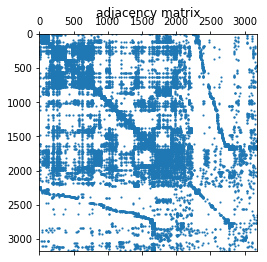

In [10]:
plt.spy(adjacency, markersize=1)
plt.title('adjacency matrix')

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [11]:
L = unweight_adj.sum()
print(n_nodes)
L_max = n_nodes*(n_nodes-1)
sparsity = L/L_max

print("L =", L)
print("L_max =", L_max)
print("sparsity :", sparsity)

3186
L = 36434
L_max = 10147410
sparsity : 0.003590472839867513


**Answers:** <br>
There are $L = 36434$ links in our network. <br>
For a $N$ node directed network, the maximum number of links is : $L_{max} = {{N}\choose{2}}*2 = 10147410$, because is represents the total number of possibilities for choosing two nodes among the $N$ (and drawing a link between them), in each direction. $L_{max}$ is reached if every node is connected with every other one in the network, in both directions (such a graph is called _complete graph_). <br>
Here $L << L_{max}$, so the network is sparse.

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

**Answer:** <br>
Our graph is directed : each route has a source airport and a destination airport. However, by intuition we can guess that if there exist a flight route from an airport A to an airport B, there probably also exist a flight route from airport B to airport A. The shape of the adjacency matrix plotted at the beginning of part 2 seems to confirm that hypothesis, because it seems symmetric. Since this symmetric property is only intuition, we will still compute the adjacency matrix of the undirected graph (we will see later that the original graph was indeed, surprisingly not symmetric). <br>

In [12]:
undir_adj = adjacency + adjacency.T
undir_unweight_adj = undir_adj
undir_unweight_adj[undir_unweight_adj>0] = 1
print("Adjacency (10 first nodes): \n", adjacency[0:10,0:10])
print("\nSymmetric Adjacency (10 first nodes): \n", undir_adj[0:10,0:10])

Adjacency (10 first nodes): 
 [[0 1 1 1 2 0 0 0 0 0]
 [1 0 1 1 1 2 0 0 0 0]
 [1 1 0 1 2 2 0 0 0 0]
 [1 1 1 0 2 0 0 0 0 0]
 [2 1 2 2 0 1 0 0 0 0]
 [0 2 2 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

Symmetric Adjacency (10 first nodes): 
 [[0 1 1 1 1 0 0 0 0 0]
 [1 0 1 1 1 1 0 0 0 0]
 [1 1 0 1 1 1 0 0 0 0]
 [1 1 1 0 1 0 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 0]
 [0 1 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


**Comments:** <br>
For the undirected graph, we have chosen to consider the edge weights as being the sum of the edge weights in both directions from the directed graph. The new weights are the total number of airlines taking a route, disregarding in which direction.
We have also chosen to build an unweighted symmetric adjacency matrix, to make things easier for the following questions (in particular when we need to use the node degree).

### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [15]:
np.save('data/adjacency_sym_mtx', undir_adj)
routes.to_csv('data/routes.csv')
features.to_csv('data/nodes.csv')

### Question 4

Are the edges of your graph weighted?

**Answer:** <br>
The edges are weighted. The weights represent the number of airlines taking each route. If the same airline uses the route in both ways, then it will be counted twice. We will see later if it is relevant (or not) to check if the airlines are disctinct.

### Question 5

What is the degree distibution of your network? 

In [12]:
degree = np.sum(undir_unweight_adj, axis = 0)
degree

array([4, 7, 9, ..., 2, 1, 1])

Execute the cell below to see the histogram of the degree distribution.

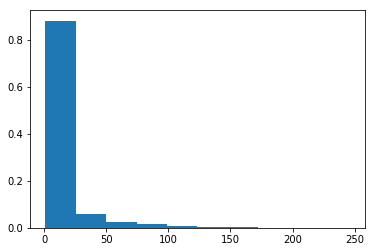

In [13]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

What is the average degree?

In [14]:
av_degree=np.mean(degree)
av_degree

11.71217363950928

### Question 6

Comment on the degree distribution of your network.

**Answer :** <br>
The large majority of the nodes have degree between 0 and 25. There are however also some nodes which have a much higher degree as we can see on the histogram : some have degree between 50 and almost 200, and even a degree larger than 200. These are hubs. This is not a random network at all. No binomial distribution shape. It rather follows a power-law distribution.

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [15]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    visited = set()
    dfs(adjacency, visited, 0)
    return len(visited) == adjacency.shape[0]

def dfs(adjacency, visited, row):
    """Performs a recursive DFS (depth-first search)
    
    Parameters
    ----------
    adjacency: numpy array
        The weighted adjacency matrix of a graph
    
    visited: An unordered collection (set)
        A set of all visited nodes
    row: an integer
        the row to check of the adjacency matrix
        
    Returns
    -------
    void
        Fill the visited list. 
        !!Note that a cleaner version can use tuple for immutability but consumes much more memory.!!
    
    """
    for idx, e in enumerate(adjacency[row]):
        if e > 0 and idx not in visited:
            visited.add(idx)
            dfs(adjacency, visited, idx)

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [16]:
print("Our graph is", "" if connected_graph(adjacency) else "not", "connected.")

Our graph is not connected.


### Question 8

Write a function that extracts the connected components of a graph.

In [17]:
def bfs(adjacency, node):
    """Performs an iterative BFS (breadth-first search)
    
    Parameters
    ----------
    adjacency: numpy array
        The weighted adjacency matrix of a graph
    
    node: an integer
        the row to check of the adjacency matrix
        
    Returns
    -------
    numpy array
        An array of indices of a set of nodes connected together (i.e. a component)
    
    """

    queue = [node]
    belonging = [node]
    while queue:
        for idx, e in enumerate(adjacency[queue.pop(0)]):
            if e > 0 and idx not in belonging:
                belonging.append(idx)
                queue.append(idx)
    
    return np.array(belonging)
        
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    # Assert the matrix is symmetric
    assert np.array_equal(adjacency, adjacency.T), "The adjacency matrix is not symmetric"
    label = 1
    n_nodes = adjacency.shape[0]
    
    # Label each nodes with a '0'
    testing_nodes = np.zeros(n_nodes, dtype=int)
    next_candidate = 0
    components = []
    adj_matrices = []
    
    # NOTE, components keep track of ID's of each connected components. When doing a list of adj
    # matrices, then we lose track of which node is which.
    while np.count_nonzero(testing_nodes) < n_nodes:
        
        # Look for the index of the next 0 value. It exists thanks to the condition of the while just above
        next_candidate = np.argmin(testing_nodes)
        
        # Store the indices of a component
        components.append(bfs(adjacency, next_candidate))
        
        # Labelize theses indices
        testing_nodes[components[-1]] = label
        label += 1
        
        # Construct an adjacency matrix using the indices found
        adj = adjacency[components[-1]]
        adj = adj[:, components[-1]]
        
        # Assert the new adjacency matrix is symmetric
        assert np.array_equal(adj, adj.T), "an adjacency matrix was not symmetric"
        
        
        # This line is not required, but could be useful to keep track
        #adj = np.insert(adj, 0, components[-1], axis=0)
        
        adj_matrices.append(adj)
        
    
    return adj_matrices

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [30]:
#Number of connected components
components = find_components(undir_adj) #TODO the adjacency matrix seems not symmetric
nb_comp = len(components)
print("There are", nb_comp, "components in our network.")

#Size of each connected component
print("\nThe size of each connected component is the following :")
comp_size = list(map(len, components))
print(comp_size)

print("\nThe size of the largest component is ",max(comp_size))

AssertionError: The adjacency matrix is not symmetric

### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [19]:
def compute_shortest_path_lengths(adjacency, source):
    """Compute the shortest path length between a source node and all nodes.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    
    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list should be of length n_nodes.
    """
    
    # (AP)
    # Dijkstra algorithm
    # we assume that adjacency is connected, otherwise the result will have another length
    P = set()
    n_nodes = adjacency.shape[0]
    d = [np.inf] * n_nodes
    d[source] = 0
    
    while len(P) < n_nodes:

        # take a node not yet visited with smallest distance
        new_nodes = list((set(range(n_nodes)) - P))
        values = [d[n] for n in new_nodes]
        min_distance_node = new_nodes[values.index(min(values))]
        
        # add it to P
        P.add(min_distance_node)
        
        # get the neighbors of this node which are not in P
        neighbors = [n for n in range(n_nodes) if not n in P and adjacency[min_distance_node, n] > 0]
        
        # update the neighbors if the new path is better than the previous solution
        for neighbor in neighbors:
            new_path = d[min_distance_node] + 1 # to use the weighted graph, replace '+1' by  '+row[neighbor]'
            d[neighbor] = min(d[neighbor], new_path)
    return d

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [20]:
mini_adj = undir_adj[:300,:300]

diameter = 0

for idx, val in enumerate(mini_adj[:, 0]):
    shortest_path_from_idx = compute_shortest_path_lengths(mini_adj, idx)
    max_ = np.nanmax(np.ma.masked_equal(shortest_path_from_idx, np.inf))
    diameter = max(diameter, max_)


In [21]:
print(diameter)

9.0


**Comments :** <br>
For this question we have simply decided to take the first 300 entries in the adjacency matrix (both dimensions).

### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [22]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.
    
    Returns
    -------
    int
        The number of paths.
    """
    # First make sure the matrix is unweighted  TODO why? Couldn't we work with the unweighte one?
    adjacency_uw = adjacency
    adjacency_uw[adjacency_uw > 0] = 1
    
    adjacency_pow = np.linalg.matrix_power(adjacency_uw, length)
    n_paths = adjacency_pow[source, target]
    
    return n_paths

Test your function on 5 pairs of nodes, with different lengths.

In [23]:
print(compute_paths(undir_adj, 0, 10, 1))
print(compute_paths(undir_adj, 0, 10, 2))
print(compute_paths(undir_adj, 0, 10, 3))
print(compute_paths(undir_adj, 23, 67, 2))
print(compute_paths(undir_adj, 15, 93, 4))

0
0
0
1
0


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [29]:
# Compute the symmetric unweighted adjacency matrix to the power of 3, and sum all the entries.
adjacency_pow = np.linalg.matrix_power(undir_adj, 3) #2 use adjacency || !2 use adjacency ?

#TODO Explain Why the number is odd? Do We have then to divide by two the non-diagonal paths if we argue to use an unweighted matrix?
#TODO or instead use the adjacency one? the running time seems affordable
result = np.sum(adjacency_pow)
print("The total number of path of length 3 is :", result)

The total number of path of length 3 is : 152887223


**Comments:** <br>
If we raise the adjacency matrix to power p, then the element at index (i,j) is the number of path of length p from i to j. Since we want the total number of path of length 3 in the graph, we raise the adjacency (symmetric and unweighted) matrix to the power 3, and sum all the entries of the matrix.

### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [25]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
  
    n_nodes = adjacency.shape[0]
    
    # Select neighbours of the node
    neighbors = [n for n in range(n_nodes) if adjacency[node, n] > 0]
    n_neighbors = len(neighbors)
    
    if n_neighbors < 2:
        return 0
    
    # Count the connections between each pair of neighbour node
    neighbor_connections = 0
    for x in neighbors:
        for y in neighbors:
            if x != y and adjacency[x, y] > 0:
                neighbor_connections += 1

    return neighbor_connections/( n_neighbors * (n_neighbors-1) )

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [26]:
# TODO Wouldn't it be better to name it sum_coeff?
mean = 0
for idx, node in enumerate(undir_adj[0]):
    mean += compute_clustering_coefficient(undir_adj, idx)
    
mean_clust_coeff = mean / undir_adj.shape[0]
print("The average clustering coefficient is :",mean_clust_coeff)

The average clustering coefficient is : 0.490589679291771
